In [23]:
import pandas as pd
import numpy as np
from skimpy import clean_columns
from pickle import load
import os
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
## Load the training and validation data
base_path = "C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task1"
train_df = pd.read_csv(base_path + "/data/heart_failure/train_val_split.csv").pipe(
        clean_columns)
X_train = train_df.drop(columns=["heart_disease"], axis=1)
X_train = X_train.drop(366)
y_train = train_df["heart_disease"]
y_train = y_train[X_train.index]

# create categorical variable for cholesterol level
X_train["chol_level"] = pd.cut(
    X_train["cholesterol"],
    bins=[-1, 100, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"]
)



In [3]:
## Load the test data
test_df = pd.read_csv(base_path + "/data/heart_failure/test_split.csv").pipe(clean_columns)
X_test = test_df.drop(columns=["heart_disease"], axis=1)
# create categorical variable for cholesterol
X_test["chol_level"] = pd.cut(
    X_test["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"]
)
y_test = test_df["heart_disease"].to_numpy()

In [4]:
# Preprocess the data
preprocessor = load(open(base_path + "/models/preprocessor.pkl", "rb"))

In [5]:
# Apply the preprocessor to the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [6]:
# Get the name of the transformed features
names_cleaned = [
    "Age",
    "Resting Blood Pressure",
    "Cholesterol",
    "Maximum Heart Rate",
    "Old Peak",
    "Sex Female",
    "Sex Male",
    "Chest Pain: Type Asymptomatic",
    "Chest Pain: Type Atypical Angina",
    "Chest Pain: Type Non-Anginal Pain",
    "Chest Pain: Type Typical Angina",
    "Fasting Blood Sugar < 120 mg/dl",
    "Fasting Blood Sugar > 120 mg/dl",
    "Resting ECG: Left Ventricular Hypertrophy",
    "Resting ECG: Normal",
    "Resting ECG: ST-T Wave Abnormality",
    "Exercise-Induced Angina: No",
    "Exercise-Induced Angina: Yes",
    "ST Slope: Downsloping",
    "ST Slope: Flat",
    "ST Slope: Upsloping",
    "Cholesterol Level: Borderline",
    "Cholesterol Level: High",
    "Cholesterol Level: Imputed",
    "Cholesterol Level: Normal"
]

In [7]:
# Create a dataframe with the transformed data
df_train = pd.DataFrame(data=X_train, columns=names_cleaned)

In [8]:
# Fit the model
Lasso = LogisticRegressionCV(cv=10, random_state=0).fit(df_train, y_train)

In [9]:
# Get the name of the transformed features
numeric_feature_names = preprocessor.named_transformers_[
    "numeric"
].get_feature_names_out()
categorical_feature_names = preprocessor.named_transformers_[
    "categorical"
].get_feature_names_out()
names = np.concatenate([numeric_feature_names, categorical_feature_names])
print(f"{names=}")

names=array(['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'sex_F',
       'sex_M', 'chest_pain_type_ASY', 'chest_pain_type_ATA',
       'chest_pain_type_NAP', 'chest_pain_type_TA', 'fasting_bs_0',
       'fasting_bs_1', 'resting_ecg_LVH', 'resting_ecg_Normal',
       'resting_ecg_ST', 'exercise_angina_N', 'exercise_angina_Y',
       'st_slope_Down', 'st_slope_Flat', 'st_slope_Up',
       'chol_level_borderline', 'chol_level_high', 'chol_level_imputed',
       'chol_level_normal'], dtype=object)


In [10]:
# Create a test dataframe with the transformed data
df_test = pd.DataFrame(data=X_test, columns=names_cleaned)
# Predict the target variable
y_pred = Lasso.predict(df_test)

In [11]:
# Compute the f1 score and the balanced accuracy
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

In [25]:
print(f"Lasso model f1 score on training data: {f1}")

Lasso model f1 score on training data: 0.8660714285714286


In [26]:
print(f"Lasso model bal_acc score on training data: {bal_acc}")

Lasso model bal_acc score on training data: 0.826044226044226


In [29]:
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Lasso auc value on training data: {bal_acc}")


Lasso auc value on training data: 0.826044226044226


In [15]:
print(f"Lasso model score on training data: {Lasso.score(df_train, y_train)}")
print(f"Lasso model score on testing data: {Lasso.score(df_test, y_test)}")

Lasso model score on training data: 0.8908594815825375
Lasso model score on testing data: 0.8369565217391305


In [30]:
# Metchin the coefficients with the feature names
coefs = pd.DataFrame(
    Lasso.coef_[0], columns=["Coefficients"], index=names_cleaned
)
coefs

,Coefficients
Age,0.244930
Resting Blood Pressure,0.048403
Cholesterol,-0.324452
Maximum Heart Rate,-0.089785
Old Peak,0.493382
Sex Female,-0.728503
Sex Male,0.724588
Chest Pain: Type Asymptomatic,1.104704
Chest Pain: Type Atypical Angina,-0.711024
Chest Pain: Type Non-Anginal Pain,-0.382697


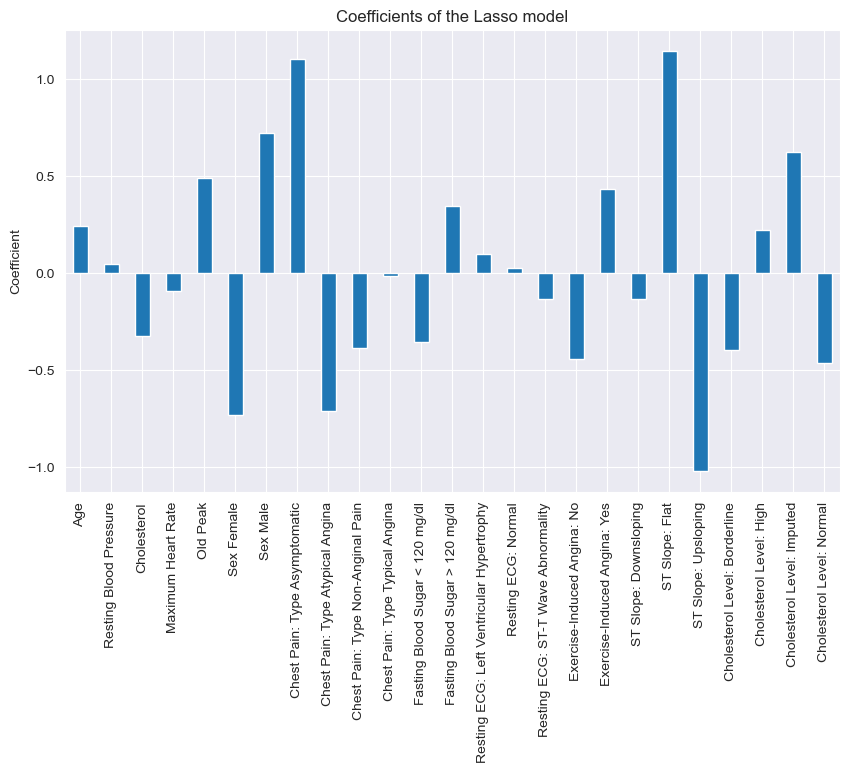

In [31]:
# plot the coefficients of the Lasso model
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
coefs["Coefficients"].plot(kind="bar")
plt.xticks(range(len(coefs)), coefs["Name"], rotation=90)
plt.ylabel("Coefficient")
plt.title("Coefficients of the Lasso model")
plt.show()

C:\Users\gianf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


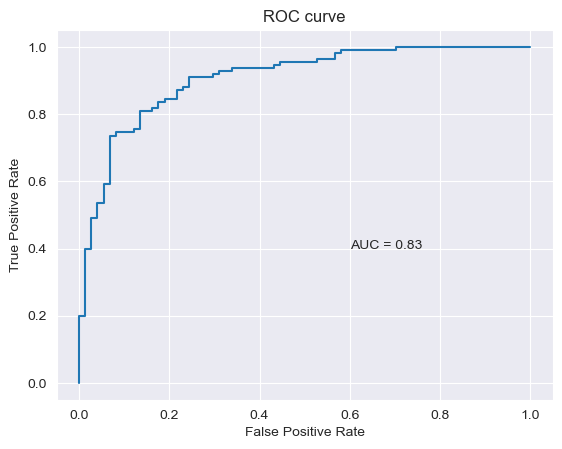

In [32]:
# plot roc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, Lasso.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# write the AUC in the plot
plt.annotate(f"AUC = {roc_auc:.2f}", (0.6, 0.4))

plt.show()


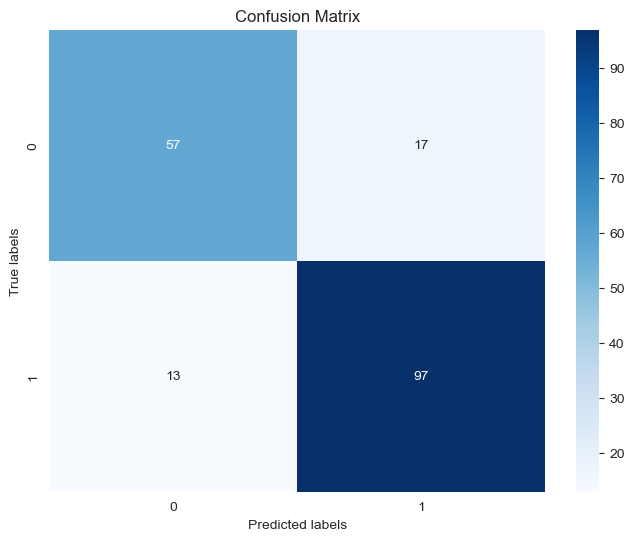

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
# Application of permutation importance
from sklearn.inspection import permutation_importance
r = permutation_importance(Lasso, df_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    print(f"{names_cleaned[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")


ST Slope: Flat0.014 +/- 0.015
ST Slope: Upsloping0.014 +/- 0.012
Cholesterol0.012 +/- 0.009
Chest Pain: Type Asymptomatic0.012 +/- 0.009
Fasting Blood Sugar > 120 mg/dl0.009 +/- 0.007
Fasting Blood Sugar < 120 mg/dl0.009 +/- 0.007
Cholesterol Level: Imputed0.008 +/- 0.007
Chest Pain: Type Non-Anginal Pain0.004 +/- 0.006
Exercise-Induced Angina: Yes0.004 +/- 0.006
Exercise-Induced Angina: No0.004 +/- 0.006
Age     0.003 +/- 0.008
Chest Pain: Type Atypical Angina0.003 +/- 0.006
Maximum Heart Rate0.002 +/- 0.004
Old Peak0.002 +/- 0.014
Cholesterol Level: Borderline0.001 +/- 0.005
Resting ECG: Left Ventricular Hypertrophy0.000 +/- 0.000
Resting ECG: Normal0.000 +/- 0.000
Resting ECG: ST-T Wave Abnormality0.000 +/- 0.000
Chest Pain: Type Typical Angina0.000 +/- 0.000
ST Slope: Downsloping0.000 +/- 0.000
Resting Blood Pressure0.000 +/- 0.000
Cholesterol Level: Normal-0.001 +/- 0.005
Sex Male-0.002 +/- 0.009
Sex Female-0.002 +/- 0.009
Cholesterol Level: High-0.003 +/- 0.005


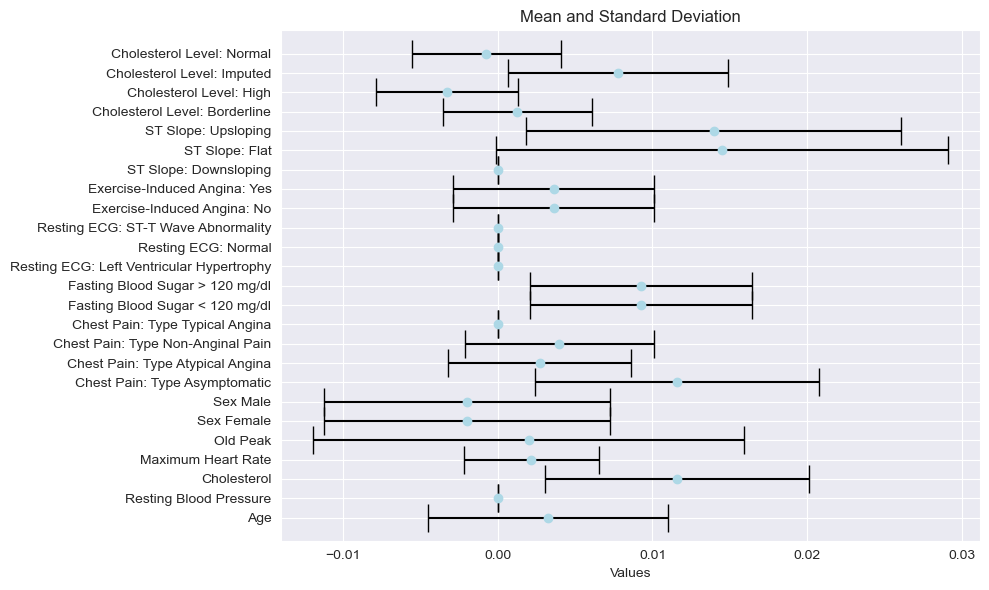

In [35]:
plt.figure(figsize=(10, 6))
plt.errorbar(means, range(len(means)), xerr=sds, fmt='o', color='lightblue', ecolor='black', capsize=10)
plt.yticks(range(len(names_cleaned)), names_cleaned)
plt.xlabel('Values')
plt.title('Mean and Standard Deviation')
plt.tight_layout()
plt.show()